In [1]:
from astropy.table import Table
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import h5py
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 5.0
plt.rcParams['xtick.minor.size'] = 3.0
plt.rcParams['ytick.major.size'] = 5.0
plt.rcParams['ytick.minor.size'] = 3.0
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True
from time import time
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
import pandas as pd
from gaiaxpy import generate, PhotometricSystem

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
%%bash
cd /scratch/
pwd

/scratch


In [4]:
# scalers for dataloading
# metscaler = MinMaxScaler()
# logscaler = MinMaxScaler()
# tefscaler = MinMaxScaler()
# amscaler = MinMaxScaler()
# scalerlist = [MinMaxScaler() for _ in range(110)] # Hardcoded since we know number of xp coefficients is static
# scale = 'MLP_MinMax'

metscaler = PowerTransformer()
logscaler = PowerTransformer()
tefscaler = PowerTransformer()
amscaler = PowerTransformer()
scalerlist = [PowerTransformer() for _ in range(110)]
scale = 'MLP_Power'

batchlen = 32
lr = 1e-2
epochs = 2
optimize = 'SGD'
datafname = '/arc/home/aydanmckay/input_catalogue_simple_average_hugedatacuts.h5'
lossname = 'L2'
# datafname = '/arc/home/aydanmckay/input_catalogue_datacuts.h5'

In [5]:
# defining the Dataset class
class train_set(Dataset):
    def __init__(self,file):
        fn = h5py.File(file, 'r')
        self.f = fn
        
        # get data
        dset = fn['group_1']['data']
        self.x = torch.Tensor(dset[:].T)
        
        # get label
        ydset = self.f['group_1']['label']
        self.y = torch.Tensor(ydset[:].T)
        # torch.from_numpy(y[index]) does not work since y is doubles and not floats.
        
        # get error in label # comment out for non-error label runs
        errdset = self.f['group_1']['e_label']
        self.err = torch.Tensor(errdset[:].T)
        
    def __len__(self):
        return self.f['group_1']['data'].shape[1]
  
    def __getitem__(self, index):
        xg = self.x[index]
        yg = self.y[index]
        errg = self.err[index]
        return (xg,yg,errg)

class valid_set(Dataset):
    def __init__(self,file):
        fn = h5py.File(file, 'r')
        self.f = fn
        
        # get data
        dset = self.f['group_2']['data']
        self.x = torch.Tensor(dset[:].T)
        
        # get label
        ydset = self.f['group_2']['label']
        self.y = torch.Tensor(ydset[:].T)
        # torch.from_numpy(y[index]) does not work since y is doubles and not floats.
        
        # get error in label # comment out for non-error label runs
        errdset = self.f['group_2']['e_label']
        self.err = torch.Tensor(errdset[:].T)
        
    def __len__(self):
        return self.f['group_2']['data'].shape[1]
  
    def __getitem__(self, index):
        xg = self.x[index]
        yg = self.y[index]
        errg = self.err[index]
        return (xg,yg,errg)

class new_data_set(Dataset):
    def __init__(self,file,train=True,valid=False,test=False,noscale=False):
        fn = h5py.File(file, 'r')
        self.f = fn
        
        # get data
        dset = fn['group_1']['data']
        d = dset[:]
        dat = np.array([
            metscaler.fit_transform(d[[0]].T).flatten(),
            logscaler.fit_transform(d[[1]].T).flatten(),
            tefscaler.fit_transform(d[[2]].T).flatten(),
            # amscaler.fit_transform(d[[3]].T).flatten(), # comment out if not
        ])
        if train:
            self.l = dat.shape[1]
            self.x = torch.Tensor(dat.T)
        elif valid:
            dset = fn['group_2']['data']
            d = dset[:]
            dat = np.array([
                metscaler.transform(d[[0]].T).flatten(),
                logscaler.transform(d[[1]].T).flatten(),
                tefscaler.transform(d[[2]].T).flatten(),
                # amscaler.transform(d[[3]].T).flatten(), # comment out if not
            ])
            self.l = dat.shape[1]
            self.x = torch.Tensor(dat.T)
        elif test:
            dset = fn['group_3']['data']
            d = dset[:]
            dat = np.array([
                metscaler.transform(d[[0]].T).flatten(),
                logscaler.transform(d[[1]].T).flatten(),
                tefscaler.transform(d[[2]].T).flatten(),
                # amscaler.transform(d[[3]].T).flatten(), # comment out if not
            ])
            self.l = dat.shape[1]
            self.x = torch.Tensor(dat.T)
        elif noscale:
            dset = fn['group_3']['data']
            d = dset[:]
            self.l = d.shape[1]
            self.x = torch.Tensor(d.T)
        
        # get label
        ydset = self.f['group_1']['label']
        yd = ydset[:]
        ydat = np.array([
            scaler.fit_transform(yd[[it]].T).flatten() for it,scaler in enumerate(scalerlist)
        ])
        # ydat=yd
        if train:
            self.y = torch.Tensor(ydat[:].T) # torch.from_numpy(y[index]) does not work since y is doubles and not floats.
        elif valid:
            ydset = self.f['group_2']['label']
            yd = ydset[:]
            ydat = np.array([
                scaler.transform(yd[[it]].T).flatten() for it,scaler in enumerate(scalerlist)
            ])
            # ydat = yd
            self.y = torch.Tensor(ydat[:].T)
        elif test:
            ydset = self.f['group_3']['label']
            yd = ydset[:]
            ydat = np.array([
                scaler.transform(yd[[it]].T).flatten() for it,scaler in enumerate(scalerlist)
            ])
            # ydat = yd
            self.y = torch.Tensor(ydat[:].T)
        elif noscale:
            ydset = self.f['group_3']['label']
            yd = ydset[:]
            self.y = torch.Tensor(yd.T)
        
        # get error in label # comment out for non-error label runs
        if train:
            errdset = self.f['group_1']['e_label']
            self.err = torch.Tensor(errdset[:].T)
        elif valid:
            errdset = self.f['group_2']['e_label']
            self.err = torch.Tensor(errdset[:].T)
        elif test or noscale:
            errdset = self.f['group_3']['e_label']
            self.err = torch.Tensor(errdset[:].T)
        
    def __len__(self):
        return self.l
  
    def __getitem__(self, index):
        xg = self.x[index]
        yg = self.y[index]
        errg = self.err[index]
        return (xg,yg,errg)

In [6]:
class ResBlock(nn.Module):
    def __init__(self, nodes):
        super(ResBlock, self).__init__()
        self.res_block1 = nn.Sequential(
            nn.Linear(nodes,nodes),
            nn.BatchNorm1d(nodes),
            nn.LeakyReLU(),
        )
        self.res_block2 = nn.Sequential(
            nn.Linear(nodes,nodes),
            nn.BatchNorm1d(nodes),
        )
        self.lrelu = nn.LeakyReLU()
#         add dropout in the init
        self.do = nn.Dropout() #
    
    def forward(self, x):
        res = x
        x = self.res_block1(x)
        x = self.res_block2(x)
        x = x + res
        output = self.lrelu(x)
#         add dropout after the relu
        output = self.do(x) #
        return output
        
class ResNetMcK(nn.Module):
    def __init__(self):
        super(ResNetMcK, self).__init__()
        self.input_block = nn.Sequential(
            nn.Linear(3,16),
            nn.LeakyReLU(),
        )
        self.blocklist = nn.ModuleList([
            ResBlock(16),
            ResBlock(16),
            nn.Linear(16,32),
            ResBlock(32),
            ResBlock(32),
            nn.Linear(32,64),
            ResBlock(64),
            ResBlock(64),
            nn.Linear(64,128),
            ResBlock(128),
            ResBlock(128),
        ])
        self.output_block = nn.Sequential(
            nn.Linear(128,110),
        )
        
    def forward(self,x):
        x = self.input_block(x)
        for i, _ in enumerate(self.blocklist):
            x = self.blocklist[i](x)
        logits = self.output_block(x)
        return logits

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(3, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 256),
            nn.LeakyReLU(),
            # nn.Linear(256, 512),
            # nn.LeakyReLU(),
            # nn.Linear(512, 110),
            nn.Linear(256,110),
            nn.Sigmoid(),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

# try 3-layer simple network with sigmoid

In [7]:
training_data = new_data_set(datafname)
valid_data = new_data_set(datafname,train=False,valid=True)

In [8]:
train_dataloader = DataLoader(
    training_data,
    batch_size=batchlen,
    shuffle=True,
    num_workers=0
)
valid_dataloader = DataLoader(
    valid_data,
    batch_size=batchlen,
    shuffle=True,
    num_workers=0
)
# add gaussian noise to data

In [9]:
# model = ResNetMcK()
model = Net()
model = model.to(device)

In [10]:
if lossname == 'L1':
    loss_fn = nn.L1Loss()
elif lossname == 'L2':
    loss_fn = nn.MSELoss()
elif lossname == 'Gauss':
    loss_fn = nn.GaussianNLLLoss()
# MAELoss

In [11]:
if optimize == 'SGD':
    optimizer = torch.optim.SGD(
        model.parameters(),
        lr=lr,
        momentum=0.9,
        # weight_decay=1e-1
    )
    # weight decay -> 1e-1, 1e-3, 1e-5
elif optimize == 'Adam':
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=lr
    )

scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=1,
    gamma=0.995
)

In [12]:
def res(preds,dataloader,epoch,resi='rel'):
    fig, axs = plt.subplots(110)
    fig.set_figheight(600)
    
    with torch.no_grad():
        for num, (X, y, z) in enumerate(dataloader):
            if resi == 'rel':
                residual = (y-preds[num])/y
                string = 'Relative Residual'
            elif resi == 'err':
                residual = (y-preds[num])/z
                string = 'Residual Over Label Error'
            elif resi == 'res':
                residual = y-preds[num]
                string = 'Residual'
            for it in range(len(y.T)):
                axs[it].plot(y.T[it],residual.T[it],'k.',alpha=0.1)
                axs[it].set_xlabel('Observed XP Coefficient Value')
                axs[it].set_ylabel('Relative Residual')
                axs[it].set_title('XP Coefficient '+str(it+1)+' '+string)
                
    plt.savefig('/arc/home/aydanmckay/torchplots/test'+resi+'residualsWL1epoch'+str(epoch)+'scalecutsep5.png')
    plt.close()
    
def diagplot(preds,dataloader,epoch):
    # fig, axs = plt.subplots(110)
    # fig.set_figheight(600)
    data = []
    labels = []
    with torch.no_grad():
        for num, (X, y, z) in enumerate(dataloader):
            for datum,true in zip(X,y):
                data.append(datum)
                labels.append(true)
        plt.scatter([datum[0] for datum in data],[(pred[0]-y[0])/y[0] for pred,y in zip(preds,labels)],label='Bp Coefficient 1')
        plt.scatter([datum[0] for datum in data],[(pred[54]-y[54])/y[54] for pred,y in zip(preds,labels)],label='Rp Coefficient 1')
        plt.legend()
        plt.title('BP and RP Coefficient 1')
        plt.xlabel('Teff')
        plt.ylabel('Relative Residual')
        # plt.savefig('/arc/home/aydanmckay/torchresplots/test'+str(epoch)+'minmaxnoscalebig32diagplot.png')
        # plt.close()
        plt.show()

In [13]:
def train(dataloader, model, loss_fn, optimizer, scheduler, device):
    model.train()
    size = len(dataloader.dataset)
    running_loss = 0.
    for batch, (X, y, z) in enumerate(dataloader):
        # Compute prediction and loss
        X = X.to(device)
        y = y.to(device)
        # z = z.to(device)
        
        pred = model(X)
        loss = loss_fn(pred,y)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if (batch % 1000 == 0):
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {running_loss/(batch+1):>7f}  [{current:>5d}/{size:>5d}]")
        
    scheduler.step()
            
    print(f"loss: {running_loss/len(dataloader):>7f}  [{size:>5d}/{size:>5d}]")
    return running_loss/len(dataloader)

def valid(dataloader, model, loss_fn, epoch, device, plots = False):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    valid_loss, correct = 0, 0

    preds = []
    with torch.no_grad():
        for X, y, z in dataloader:
            X = X.to(device)
            y = y.to(device)
            # z = z.to(device)
            
            pred = model(X)
            valid_loss += loss_fn(pred, y).item()
            correct += (pred == y).type(torch.float).sum().item()
            if plots == True:
                for prediction in pred:
                    preds.append(prediction.to('cpu'))
    
    if plots == True:
        preds = np.array(preds)
        # res(preds,dataloader,epoch,resi='res')
        # res(preds,dataloader,epoch,resi='rel')
        # res(preds,dataloader,epoch,resi='err')
        diagplot(preds,dataloader,epoch)
    
    valid_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>8f}%, Avg loss: {valid_loss:>8f} \n")
    return valid_loss

In [14]:
valloss = []
traloss = []
for t in range(epochs):
    t0 = time()
    print(f"Epoch {t+1}\n-------------------------------")
    trainloss = train(
        train_dataloader,
        model,
        loss_fn,
        optimizer,
        scheduler,
        device
    )
    if (t+1) % 25 == 0:
        validloss = valid(
            valid_dataloader,
            model,
            loss_fn,
            t,
            device,
            plots = True,
        )
    else:
        validloss = valid(
            valid_dataloader,
            model,
            loss_fn,
            t,
            device,
        )
    valloss.append(validloss)
    traloss.append(trainloss)
    # torch.save({
    #             'epoch': t,
    #             'model_state_dict': model.state_dict(),
    #             'optimizer_state_dict': optimizer.state_dict(),
    #             'loss': tloss,
    #             }, '/arc/home/aydanmckay/ml/torchnn/checkpoints/checkpointWGLsmallepoch'+str(t)+'scalecutsep5.pth')
    # torch.save(model.state_dict(), "/arc/home/aydanmckay/torchmodel/torchmodelWsmallscalecutsep5iter"+str(t)+".pth")
    t1 = time()
    print(f'Elapsed epoch time: {t1-t0:.2f} s')
print("Training completed")

Epoch 1
-------------------------------
loss: 1.245283  [    0/2171960]
loss: 1.095292  [32000/2171960]
loss: 1.039697  [64000/2171960]
loss: 1.027356  [96000/2171960]
loss: 1.031837  [128000/2171960]
loss: 1.022334  [160000/2171960]
loss: 1.014996  [192000/2171960]
loss: 1.011793  [224000/2171960]
loss: 1.007903  [256000/2171960]
loss: 1.005436  [288000/2171960]
loss: 1.002638  [320000/2171960]
loss: 0.999619  [352000/2171960]
loss: 0.998636  [384000/2171960]
loss: 0.997794  [416000/2171960]
loss: 0.996591  [448000/2171960]
loss: 0.995613  [480000/2171960]
loss: 0.994146  [512000/2171960]
loss: 0.993337  [544000/2171960]
loss: 0.993063  [576000/2171960]
loss: 0.992162  [608000/2171960]
loss: 0.992426  [640000/2171960]
loss: 0.990960  [672000/2171960]
loss: 0.990655  [704000/2171960]
loss: 0.989897  [736000/2171960]
loss: 0.988954  [768000/2171960]
loss: 0.988998  [800000/2171960]
loss: 0.988626  [832000/2171960]
loss: 0.987948  [864000/2171960]
loss: 0.987341  [896000/2171960]
loss: 0

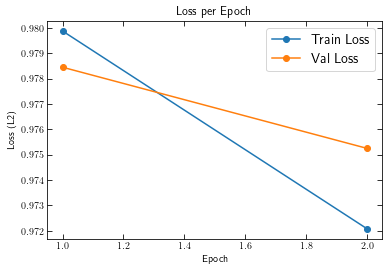

In [15]:
plt.plot(range(1,len(traloss)+1),traloss,'-o',label='Train Loss')
plt.plot(range(1,len(valloss)+1),valloss,'-o',label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (L2)')
# plt.ylim(0.65,0.67)
plt.legend(fancybox=True)
plt.title('Loss per Epoch')
batchlen = 32
lr = 1e-2
epochs = 2
plt.savefig('/arc/home/aydanmckay/torchresplots/lossplot_cleaninputcatloss'+lossname+scale+'bl'+str(batchlen)+'lr'+str(lr)+optimize+'ep'+str(epochs)+'dropout.png')
plt.show()

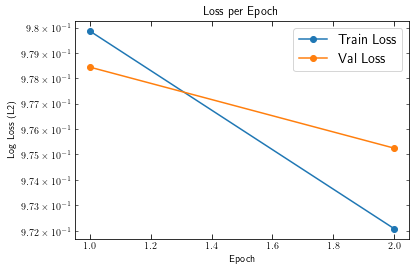

In [16]:
plt.semilogy(range(1,len(traloss)+1),traloss,'-o',label='Train Loss')
plt.semilogy(range(1,len(valloss)+1),valloss,'-o',label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Log Loss (L2)')
# plt.ylim(0.65,0.67)
plt.legend(fancybox=True)
plt.title('Loss per Epoch')
plt.savefig('/arc/home/aydanmckay/torchresplots/semiloglossplot_cleaninputcatloss'+lossname+scale+'bl'+str(batchlen)+'lr'+str(lr)+optimize+'ep'+str(epochs)+'dropout.png')
plt.show()

In [17]:
torch.save(model.state_dict(), '/arc/home/aydanmckay/torchresmodel/trainedmodel_cleaninputcatloss'+lossname+scale+'bl'+str(batchlen)+'lr'+str(lr)+optimize+'ep'+str(epochs)+'dropout.pth')

In [18]:
model.load_state_dict(torch.load('/arc/home/aydanmckay/torchresmodel/trainedmodel_cleaninputcatloss'+lossname+scale+'bl'+str(batchlen)+'lr'+str(lr)+optimize+'ep'+str(epochs)+'dropout.pth'))

<All keys matched successfully>

In [ ]:
test_data = new_data_set(datafname,train=False,test=True)
test_dataloader = DataLoader(
    test_data,
    batch_size=batchlen,
    # shuffle=True,
    num_workers=0
)
unscaled_data = new_data_set(datafname,train=False,noscale=True)
unscaled_dataloader = DataLoader(
    unscaled_data,
    batch_size=batchlen,
    # shuffle=True,
    num_workers=0
)

In [ ]:
# # throw this into a class
def mag_generator(model,loaded_data,scalerlist):
    preds = []
    covbs = []
    covrs = []
    with torch.no_grad():
        for X, y, z in loaded_data:
            X = X.to(device)
            y = y.to(device)
            z = z.to(device)
            pred = model(X)
            for prediction,err in zip(pred,z):
                covbp = np.zeros((55,55))
                covrp = np.zeros((55,55))
                preds.append(prediction)
                for it in range(len(err[:55])):
                    covbp[it][it] += err[it].item()**2
                    covrp[it][it] += err[it+55].item()**2
                covbs.append(covbp)
                covrs.append(covrp)
    preds = np.array([pred.to('cpu').numpy() for pred in preds]).T
    xpnewpred = []
    # print(pred)
    # print()
    for pred,scaler in zip(preds,scalerlist):
        xpnewpred.append(scaler.inverse_transform(np.array([pred]).T).flatten())
        # xpnewpred.append(pred)
    bpnews = np.array(xpnewpred[:55]).T
    rpnews = np.array(xpnewpred[55:]).T
    df = pd.DataFrame(
        {'source_id':range(len(preds.T)),
         'bp_coefficients':list(bpnews),
         'bp_standard_deviation':[np.std(bp) for bp in bpnews],
         'bp_coefficient_covariances':covbs,
         'rp_coefficients':list(rpnews),
         'rp_coefficient_covariances':covrs,
         'rp_standard_deviation':[np.std(rp) for rp in rpnews]
        }
    )
    # print(df)
    synthetic_photometry = generate(df, photometric_system=PhotometricSystem.Pristine)
    return synthetic_photometry

In [ ]:
synth_phot = mag_generator(model,test_dataloader,scalerlist)

In [ ]:
synth_phot

In [ ]:
# # throw this into a class
def mag_generator_unscaled(model,loaded_data):
    preds = []
    covbs = []
    covrs = []
    with torch.no_grad():
        for X, y, z in loaded_data:
            y = y.to(device)
            z = z.to(device)
            pred = y
            for prediction,err in zip(pred,z):
                covbp = np.zeros((55,55))
                covrp = np.zeros((55,55))
                preds.append(prediction)
                for it in range(len(err[:55])):
                    covbp[it][it] += err[it].item()**2
                    covrp[it][it] += err[it+55].item()**2
                covbs.append(covbp)
                covrs.append(covrp)
    preds = np.array([pred.to('cpu').numpy() for pred in preds]).T
    bpnews = np.array(preds[:55]).T
    rpnews = np.array(preds[55:]).T
    df = pd.DataFrame(
        {'source_id':range(len(preds.T)),
         'bp_coefficients':list(bpnews),
         'bp_standard_deviation':[np.std(bp) for bp in bpnews],
         'bp_coefficient_covariances':covbs,
         'rp_coefficients':list(rpnews),
         'rp_coefficient_covariances':covrs,
         'rp_standard_deviation':[np.std(rp) for rp in rpnews]
        }
    )
    synthetic_photometry = generate(df, photometric_system=PhotometricSystem.Pristine)
    return synthetic_photometry

In [ ]:
synth_phot2 = mag_generator_unscaled(model,unscaled_dataloader)

In [ ]:
synth_phot2.describe()

In [ ]:
synth_phot.describe()

In [ ]:
plt.figure(figsize=(10,7))

ax = plt.gca()
# ax.xaxis.set_minor_locator(MultipleLocator(200))
# ax.yaxis.set_minor_locator(MultipleLocator(.2))

plt.scatter(synth_phot['Pristine_mag_CaHK'],synth_phot2['Pristine_mag_CaHK'],c='k',alpha=0.03)
plt.hexbin(synth_phot['Pristine_mag_CaHK'],synth_phot2['Pristine_mag_CaHK'],mincnt=5)
plt.plot(np.arange(14,26),np.arange(14,26))
plt.xlim(13,26)
plt.xlabel('Synthetic Magnitude from Predicted Bp/Rp Spectra Coefficients')
plt.ylabel('Synthetic Magnitude from Observed Bp/Rp Spectra Coefficients')
plt.title('Generated Pristine CaHK Magnitude Comparison between Predicted an/d True Xp Coefficient Labels');
plt.savefig('/arc/home/aydanmckay/torchresplots/magplots_cleaninputcatloss'+lossname+scale+'bl'+str(batchlen)+'lr'+str(lr)+optimize+'ep'+str(epochs)+'dropout.png')